In [1]:
%cd ..

/home/eli/AnacondaProjects/ppc_experiments


In [2]:
import argparse
import collections
import numpy as np
import pyro
import torch
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
import trainer.trainer as module_trainer

In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [5]:
from utils import read_json

config = read_json("experiments/ppc_emnist_config.json")
config = ConfigParser(config)

In [6]:
logger = config.get_logger('train')

# setup data_loader instances
data_loader = config.init_obj('data_loader', module_data)
valid_data_loader = data_loader.split_validation()

# build model architecture, then print to console
model = config.init_obj('arch', module_arch)
logger.info(model)

# get function handles of metrics
metrics = [getattr(module_metric, met) for met in config['metrics']]

# build optimizer.
if "lr_scheduler" in config:
    lr_scheduler = getattr(pyro.optim, config["lr_scheduler"]["type"])
    lr_scheduler = optimizer = lr_scheduler({
        "optimizer": getattr(torch.optim, config["optimizer"]["type"]),
        "optim_args": config["optimizer"]["args"]["optim_args"],
        **config["lr_scheduler"]["args"]
    })
else:
    optimizer = config.init_obj('optimizer', pyro.optim)
    lr_scheduler = None

# build trainer
# kwargs = config['trainer'].pop('args')
trainer = config.init_obj('trainer', module_trainer, model, metrics, optimizer,
                          config=config, data_loader=data_loader,
                          valid_data_loader=valid_data_loader,
                          lr_scheduler=lr_scheduler)

MnistPpc(
  (prior): GaussianPrior()
  (decoder1): ConditionalGaussian(
    (decoder): Sequential(
      (0): ReLU()
      (1): Linear(in_features=20, out_features=128, bias=True)
    )
  )
  (decoder2): ConditionalGaussian(
    (decoder): Sequential(
      (0): ReLU()
      (1): Linear(in_features=128, out_features=256, bias=True)
    )
  )
  (likelihood): MlpBernoulliLikelihood(
    (decoder): Sequential(
      (0): ReLU()
      (1): Linear(in_features=256, out_features=784, bias=True)
    )
  )
  (graph): PpcGraphicalModel()
)
Trainable parameters: 319540
Initialize particles: train batch 0
Initialize particles: train batch 1
Initialize particles: train batch 2
Initialize particles: train batch 3
Initialize particles: train batch 4
Initialize particles: train batch 5
Initialize particles: train batch 6
Initialize particles: train batch 7
Initialize particles: train batch 8
Initialize particles: train batch 9
Initialize particles: train batch 10
Initialize particles: train batch 11
I

In [7]:
logger.info(trainer.config.log_dir)

saved/log/EMnist_Ppc/0504_153821


In [8]:
trainer.train()

Train Epoch: 1 [0/101520 (0%)] Loss: 790.410278
Train Epoch: 1 [11264/101520 (11%)] Loss: -224.198120
Train Epoch: 1 [22528/101520 (22%)] Loss: -217.371033
Train Epoch: 1 [33792/101520 (33%)] Loss: -238.801620
Train Epoch: 1 [45056/101520 (44%)] Loss: -242.810501
Train Epoch: 1 [56320/101520 (55%)] Loss: -254.510437
Train Epoch: 1 [67584/101520 (67%)] Loss: -261.337280
Train Epoch: 1 [78848/101520 (78%)] Loss: -262.173340
Train Epoch: 1 [90112/101520 (89%)] Loss: -293.183960
Train Epoch: 1 [101376/101520 (100%)] Loss: -304.521667
    epoch          : 1
    loss           : -228.58709693793676
    ess            : 1.9554264952789
    log_marginal   : 229.0655339303328
    log_joint      : 443.8189624038773
    val_loss       : -285.528308370839
    val_ess        : 1.9630526667055876
    val_log_marginal: 285.9007913340693
    val_log_joint  : 501.6078915803329
Train Epoch: 2 [0/101520 (0%)] Loss: -318.653198
Train Epoch: 2 [11264/101520 (11%)] Loss: -319.923920
Train Epoch: 2 [22528/10

In [9]:
trainer.model.eval()
trainer.model.cpu()
trainer.cpu()
trainer.train_particles.cpu()
trainer.valid_particles.cpu()

ParticleDict(
    (z1): Parameter containing: [torch.FloatTensor of size 2x11280x20]
    (z2): Parameter containing: [torch.FloatTensor of size 2x11280x128]
    (z3): Parameter containing: [torch.FloatTensor of size 2x11280x256]
)

In [10]:
trainer.model.graph.clear()
trainer._load_particles(range(trainer.data_loader.batch_size), False)

In [11]:
for site in trainer.model.graph.nodes:
    trainer.model.graph.nodes[site]['is_observed'] = trainer.model.graph.nodes[site]['value'] is not None

In [12]:
import utils

In [13]:
with pyro.plate_stack("forward", (trainer.num_particles, trainer.data_loader.batch_size)):
    model = pyro.condition(trainer.model, data={k: v['value'] for k, v in trainer.model.graph.nodes.items()})
    xs = model()

In [14]:
import matplotlib.pyplot as plt

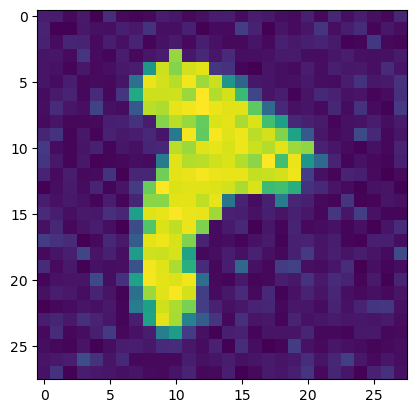

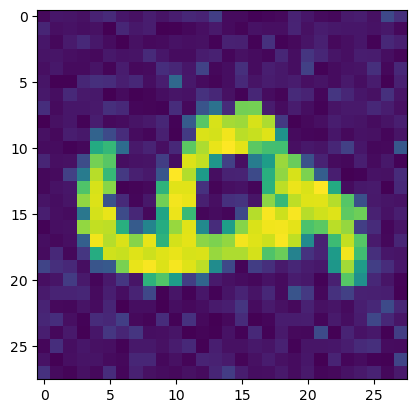

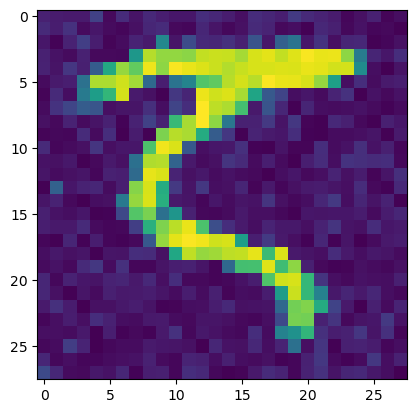

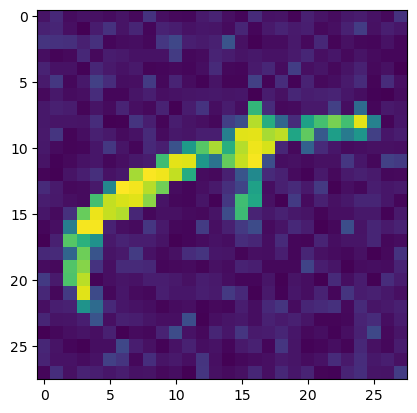

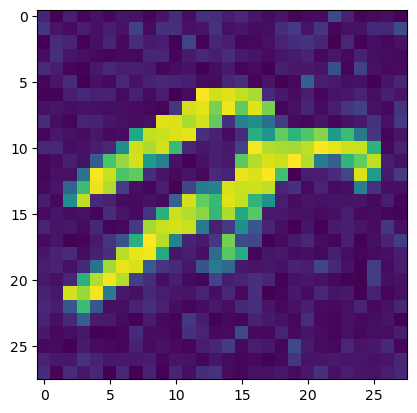

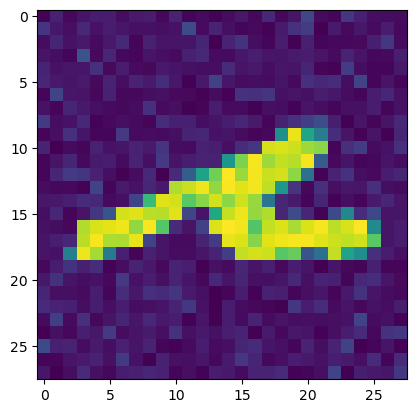

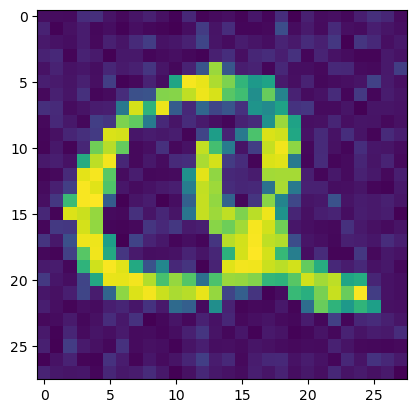

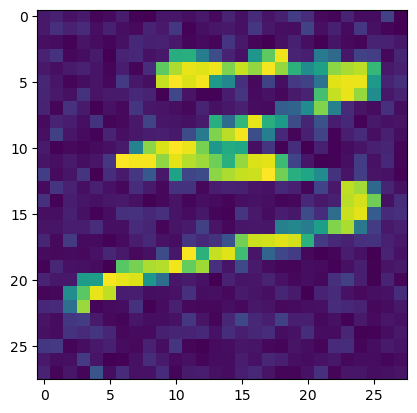

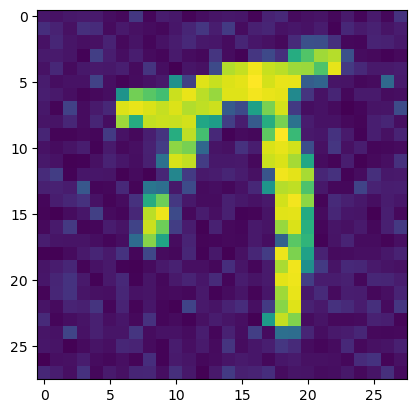

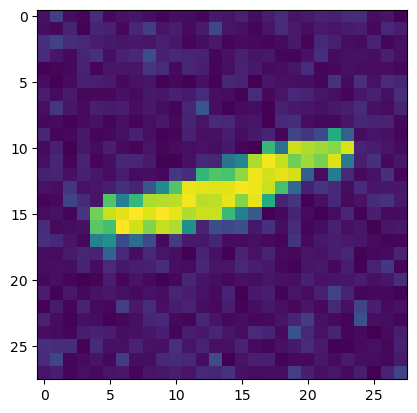

In [15]:
for i in range(10):
    plt.imshow(xs.mean(dim=0)[i].squeeze().detach().cpu().numpy())
    plt.show()